# Array distance measurements ROBAT 226.238 on 9/4/2025:

- 5 mic array adafruit 5 i2s 
- robat 226.238 at 96khz recorded with 'record_all_mics.py' file
- array on the robat 226.238 kept fixed 
- robat 226.240 moved towards it 10 cm at a time from 1 m to 10 cm 
- robat 226.240 outputting 1-40 khz sweep 20 ms at 96 khz full power from loudspeaker  

Data files 10cmC1 and 10cmC2 are the measure at 10 cm centered at mic 1 and 5 respectively of hte same signal

Output signal to match filter with the inputs 

len =  16384


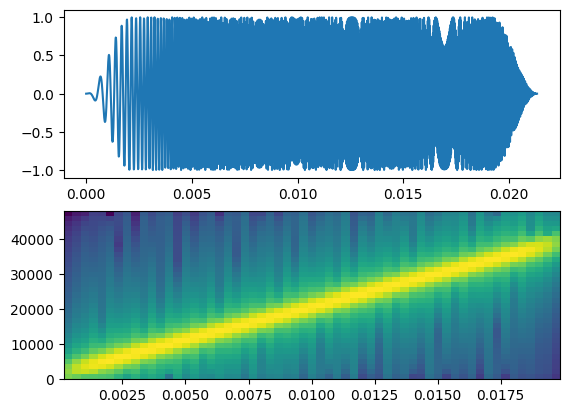

In [18]:
import sounddevice as sd
import numpy as np
import scipy.signal as signal
from matplotlib import pyplot as plt
import os
import soundfile as sf

def pow_two_pad_and_window(vec, show = True):
    window = signal.windows.tukey(len(vec), alpha=0.2)
    windowed_vec = vec * window
    padded_windowed_vec = np.pad(windowed_vec, (0, 2**int(np.ceil(np.log2(len(windowed_vec)))) - len(windowed_vec)))
    if show:
        dur = len(padded_windowed_vec) / fs
        t = np.linspace(0, dur, len(windowed_vec))
        plt.figure()
        plt.subplot(2, 1, 1)
        plt.plot(t, windowed_vec)
        plt.subplot(2, 1, 2)
        plt.specgram(windowed_vec, NFFT=64, noverlap=32, Fs=fs)
    return padded_windowed_vec/max(padded_windowed_vec)

def pow_two(vec):
    return np.pad(vec, (0, 2**int(np.ceil(np.log2(len(vec)))) - len(vec)))

if __name__ == "__main__":

    fs = 96e3
    dur = 20e-3
    hi_freq =  1e3
    low_freq = 40e3
    
    t_tone = np.linspace(0, dur, int(fs*dur))
    chirp = signal.chirp(t_tone, hi_freq, t_tone[-1], low_freq)
    sig = pow_two_pad_and_window(chirp, show=True)

    silence_dur = 100 # [ms]
    silence_samples = int(silence_dur * fs/1000)
    silence_vec = np.zeros((silence_samples, ))
    full_sig = pow_two(np.concatenate((sig, silence_vec)))
    print('len = ', len(full_sig))
    stereo_sig = np.hstack([full_sig.reshape(-1, 1), full_sig.reshape(-1, 1)])

    output_sig = np.float32(stereo_sig)

    current_frame = 0
    def callback(outdata, frames, time, status):
        global current_frame
        if status:
            print(status)
        chunksize = min(len(output_sig) - current_frame, frames)
        outdata[:chunksize] = output_sig[current_frame:current_frame + chunksize]
        if chunksize < frames:
            outdata[chunksize:] = 0
            raise sd.CallbackAbort()
        current_frame += chunksize

In [4]:
# Load audio files

DIR = "./array_calibration/226_238/dist_test/2025-04-09/original/"  # Directory containing the audio files
audio_files = os.listdir(DIR)  # List all files in the sweeps directory
audio_files.sort()  # Sort the files in ascending order

# Directory to save the extracted channels
output_dir = "./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Path to the multi-channel WAV file
for file in audio_files:
    file_path = os.path.join(DIR, file)

    dist_name = file.split('.')[0]
    print(f"Processing file: {dist_name}")

    # Read the multi-channel WAV file
    audio_data, sample_rate = sf.read(DIR + file)

    # Check the shape of the audio data
    print(f"Audio data shape: {audio_data.shape}")  # (samples, channels)

    # Extract individual channels
    num_channels = audio_data.shape[1]  # Number of channels
    channels = [audio_data[:, i] for i in range(num_channels)]

    # Save each channel as a separate WAV file
    for i, channel_data in enumerate(channels):
        output_file = os.path.join(output_dir, dist_name+f"_{i + 1}.wav")  # Path to the output file
        sf.write(output_file, channel_data, sample_rate)
        print(f"Saved channel {i + 1} to {output_file}")


Processing file: 100cm
Audio data shape: (956947, 5)
Saved channel 1 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/100cm_1.wav
Saved channel 2 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/100cm_2.wav
Saved channel 3 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/100cm_3.wav
Saved channel 4 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/100cm_4.wav
Saved channel 5 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/100cm_5.wav
Processing file: 10cm
Audio data shape: (1145705, 5)
Saved channel 1 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/10cm_1.wav
Saved channel 2 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/10cm_2.wav
Saved channel 3 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/10cm_3.wav
Saved channel 4 to ./array_calibration/226_238/dist_test/2025-04-09/extracted_channels/10cm_4.wav
Saved c

In [20]:
# List all extracted channel files separated by channel number
from natsort import natsorted
import cmath
import os

# Directory containing the extracted channels
extracted_channels_dir = "./array_calibration/226_238/dist_test/2025-04-09/extracted_channels"
os.makedirs(extracted_channels_dir, exist_ok=True)  # Create the directory if it doesn't exist

# List all extracted channel files
channel_files = os.listdir(extracted_channels_dir)

# Filter out directories, keep only files
channel_files = [f for f in channel_files if os.path.isfile(os.path.join(extracted_channels_dir, f))]

# Sort the files naturally by the last part of their names (e.g., channel number)
sorted_channel_files = natsorted(channel_files, key=lambda x: int(x.split('_')[-1].split('.')[0]))

# Group files by the last part of their name (channel number)
grouped_files = {}

for file in sorted_channel_files:
    # Extract the channel number from the file name (e.g., "350_1.wav" -> "1")
    channel_number = int(file.split('_')[-1].split('.')[0])

    # Group files by channel number
    if channel_number not in grouped_files:
        grouped_files[channel_number] = []
    grouped_files[channel_number].append(file)

for i in range(len(grouped_files)):
    grouped_files[i+1].sort(key=lambda x: int(x.split('c')[0]))

# Print grouped files
for channel_number, files in grouped_files.items():
    print(f"Channel {channel_number}:")
    for f in files:
        print(f"  {f}")

Channel 1:
  10cmC5_1.wav
  10cmC1_1.wav
  10cm_1.wav
  20cm_1.wav
  30cm_1.wav
  40cm_1.wav
  50cm_1.wav
  60cm_1.wav
  70cm_1.wav
  80cm_1.wav
  90cm_1.wav
  100cm_1.wav
Channel 2:
  10cmC5_2.wav
  10cmC1_2.wav
  10cm_2.wav
  20cm_2.wav
  30cm_2.wav
  40cm_2.wav
  50cm_2.wav
  60cm_2.wav
  70cm_2.wav
  80cm_2.wav
  90cm_2.wav
  100cm_2.wav
Channel 3:
  10cmC5_3.wav
  10cmC1_3.wav
  10cm_3.wav
  20cm_3.wav
  30cm_3.wav
  40cm_3.wav
  50cm_3.wav
  60cm_3.wav
  70cm_3.wav
  80cm_3.wav
  90cm_3.wav
  100cm_3.wav
Channel 4:
  10cmC1_4.wav
  10cmC5_4.wav
  10cm_4.wav
  20cm_4.wav
  30cm_4.wav
  40cm_4.wav
  50cm_4.wav
  60cm_4.wav
  70cm_4.wav
  80cm_4.wav
  90cm_4.wav
  100cm_4.wav
Channel 5:
  10cmC1_5.wav
  10cmC5_5.wav
  10cm_5.wav
  20cm_5.wav
  30cm_5.wav
  40cm_5.wav
  50cm_5.wav
  60cm_5.wav
  70cm_5.wav
  80cm_5.wav
  90cm_5.wav
  100cm_5.wav


Processing Channel 1:
Peaks detected in 10cmC5_1.wav: 50
RMS value of sweep at peak 12731 in 10cmC5_1.wav: 0.07122
RMS value of sweep at peak 27264 in 10cmC5_1.wav: 0.07145
RMS value of sweep at peak 40514 in 10cmC5_1.wav: 0.07148
RMS value of sweep at peak 54831 in 10cmC5_1.wav: 0.07135
RMS value of sweep at peak 67025 in 10cmC5_1.wav: 0.07137
RMS value of sweep at peak 80455 in 10cmC5_1.wav: 0.07143
RMS value of sweep at peak 94773 in 10cmC5_1.wav: 0.07108
RMS value of sweep at peak 108010 in 10cmC5_1.wav: 0.07104
RMS value of sweep at peak 122411 in 10cmC5_1.wav: 0.07124
RMS value of sweep at peak 135625 in 10cmC5_1.wav: 0.07131
RMS value of sweep at peak 150027 in 10cmC5_1.wav: 0.07132
RMS value of sweep at peak 163276 in 10cmC5_1.wav: 0.07137
RMS value of sweep at peak 177834 in 10cmC5_1.wav: 0.07157
RMS value of sweep at peak 190928 in 10cmC5_1.wav: 0.07164
RMS value of sweep at peak 205594 in 10cmC5_1.wav: 0.07155
RMS value of sweep at peak 219634 in 10cmC5_1.wav: 0.07156
RMS va

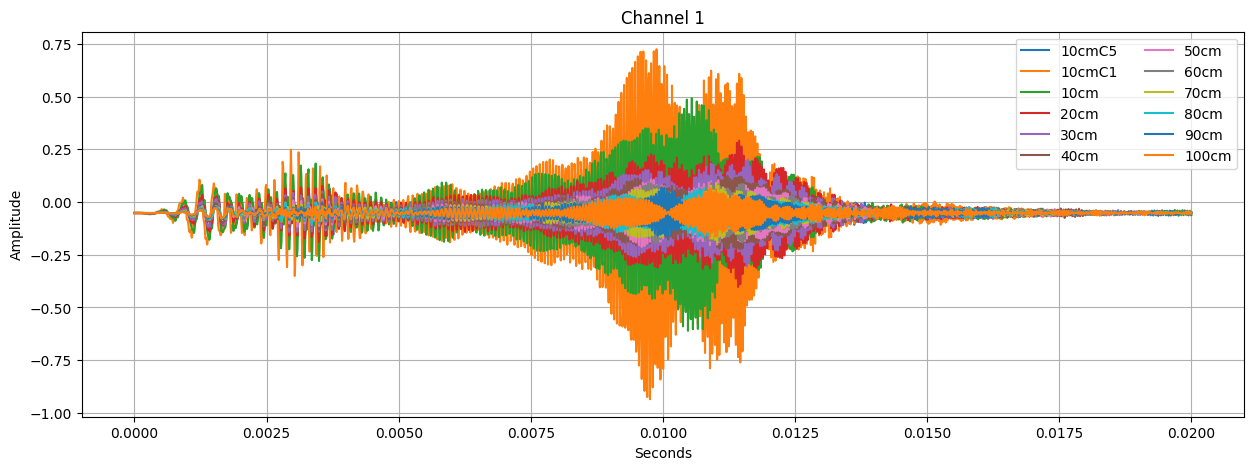

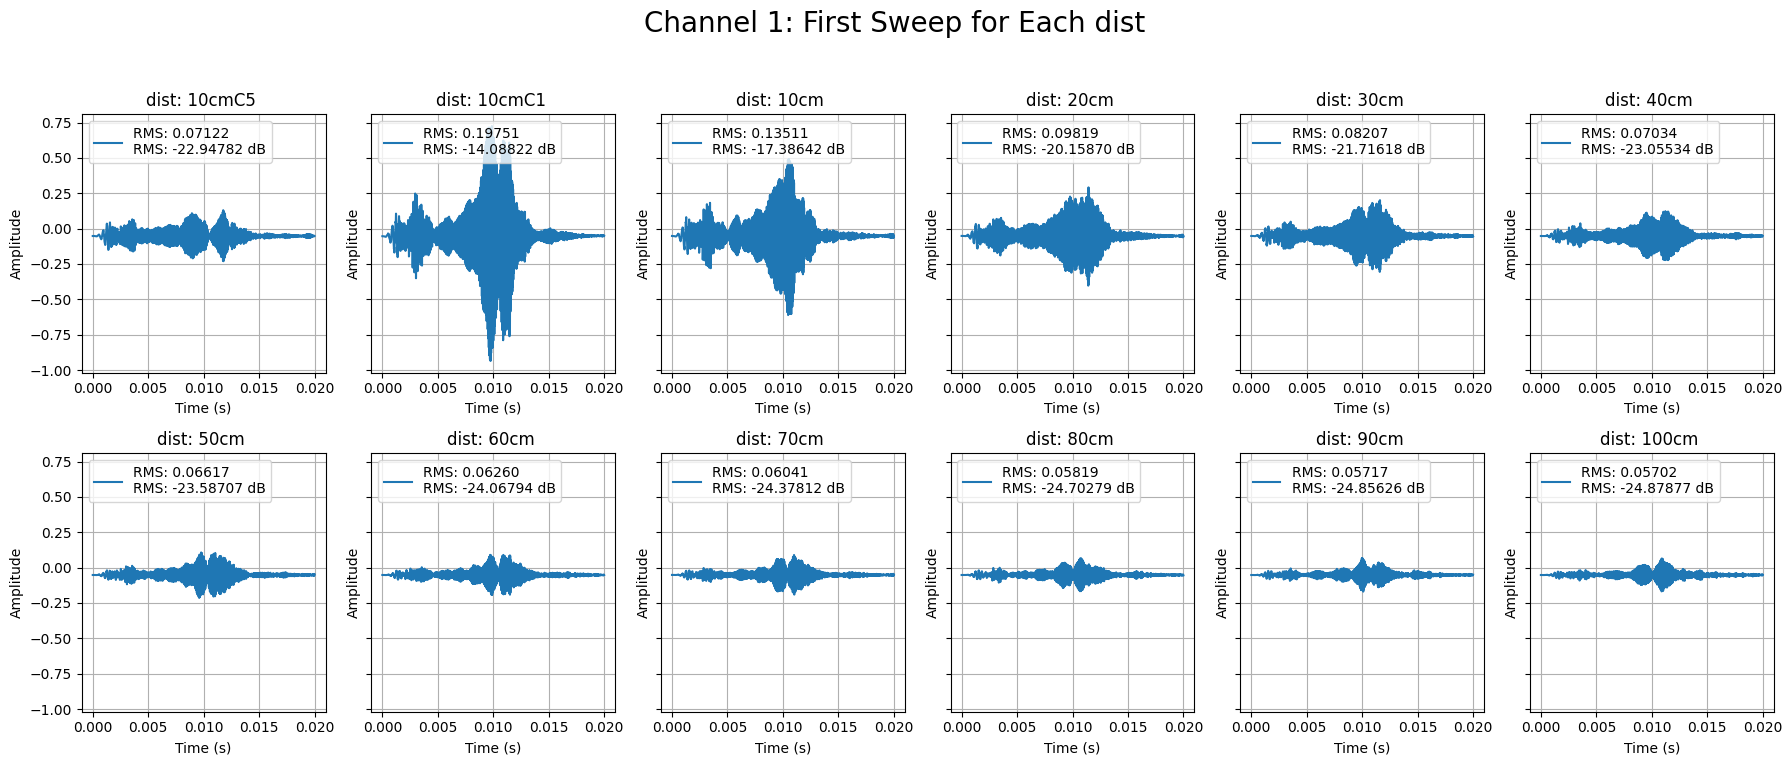

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 2:
Peaks detected in 10cmC5_2.wav: 50
RMS value of sweep at peak 12728 in 10cmC5_2.wav: 0.09135
RMS value of sweep at peak 27262 in 10cmC5_2.wav: 0.09154
RMS value of sweep at peak 40512 in 10cmC5_2.wav: 0.09169
RMS value of sweep at peak 54829 in 10cmC5_2.wav: 0.09128
RMS value of sweep at peak 67023 in 10cmC5_2.wav: 0.09123
RMS value of sweep at peak 80452 in 10cmC5_2.wav: 0.09129
RMS value of sweep at peak 94770 in 10cmC5_2.wav: 0.09087
RMS value of sweep at peak 108007 in 10cmC5_2.wav: 0.09110
RMS value of sweep at peak 122409 in 10cmC5_2.wav: 0.09105
RMS value of sweep at peak 135623 in 10cmC5_2.wav: 0.09079
RMS value of sweep at peak 150025 in 10cmC5_2.wav: 0.09094
RMS value of sweep at peak 163274 in 10cmC5_2.wav: 0.09115
RMS value of sweep at peak 177831 in 10cmC5_2.wav: 0.09153
RMS value of sweep at peak 190925 in 10cmC5_2.wav: 0.09159
RMS value of sweep at peak 205591 in 10cmC5_2.wav: 0.09142
RMS value of sweep at peak 219632 in 10cmC5_2.wav: 0.09165
RMS va

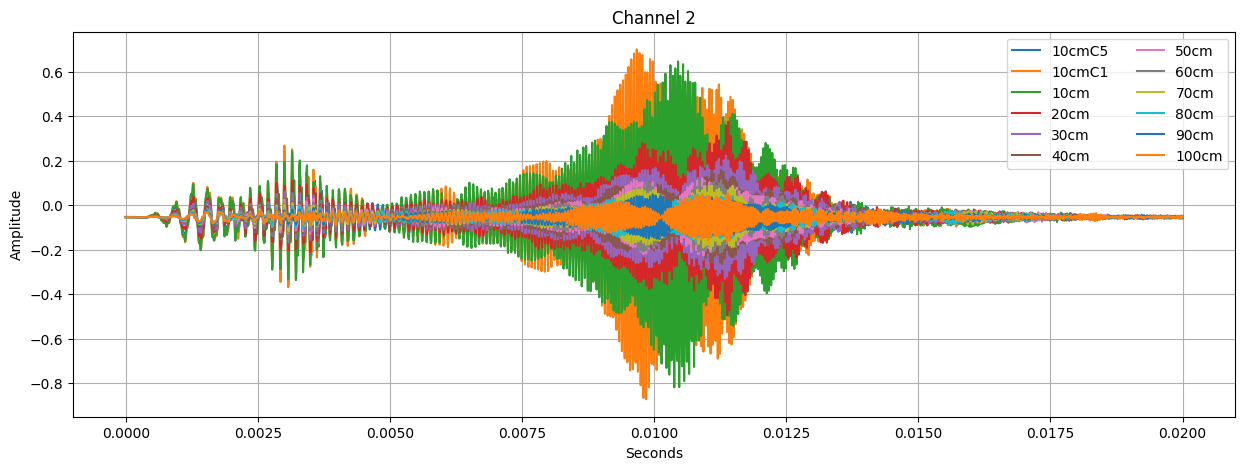

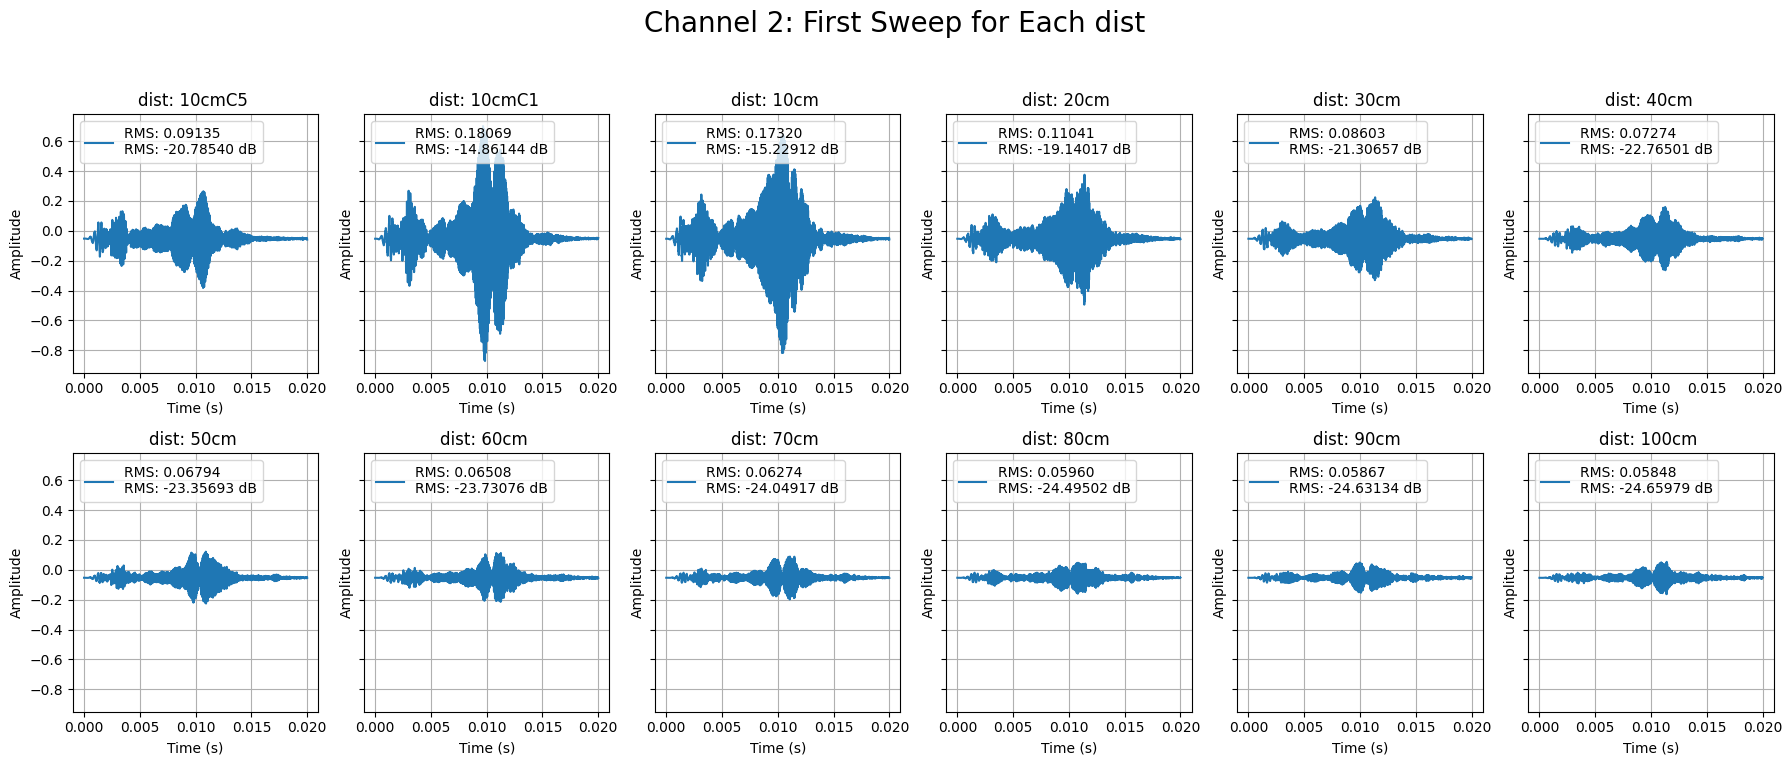

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 3:
Peaks detected in 10cmC5_3.wav: 67
RMS value of sweep at peak 12726 in 10cmC5_3.wav: 0.11360
RMS value of sweep at peak 12731 in 10cmC5_3.wav: 0.11360
RMS value of sweep at peak 27260 in 10cmC5_3.wav: 0.11379
RMS value of sweep at peak 40510 in 10cmC5_3.wav: 0.11364
RMS value of sweep at peak 54827 in 10cmC5_3.wav: 0.11316
RMS value of sweep at peak 67021 in 10cmC5_3.wav: 0.11325
RMS value of sweep at peak 80450 in 10cmC5_3.wav: 0.11304
RMS value of sweep at peak 80455 in 10cmC5_3.wav: 0.11304
RMS value of sweep at peak 94768 in 10cmC5_3.wav: 0.11274
RMS value of sweep at peak 94773 in 10cmC5_3.wav: 0.11274
RMS value of sweep at peak 108005 in 10cmC5_3.wav: 0.11272
RMS value of sweep at peak 122407 in 10cmC5_3.wav: 0.11256
RMS value of sweep at peak 135621 in 10cmC5_3.wav: 0.11297
RMS value of sweep at peak 150023 in 10cmC5_3.wav: 0.11382
RMS value of sweep at peak 163272 in 10cmC5_3.wav: 0.11436
RMS value of sweep at peak 177829 in 10cmC5_3.wav: 0.11471
RMS value

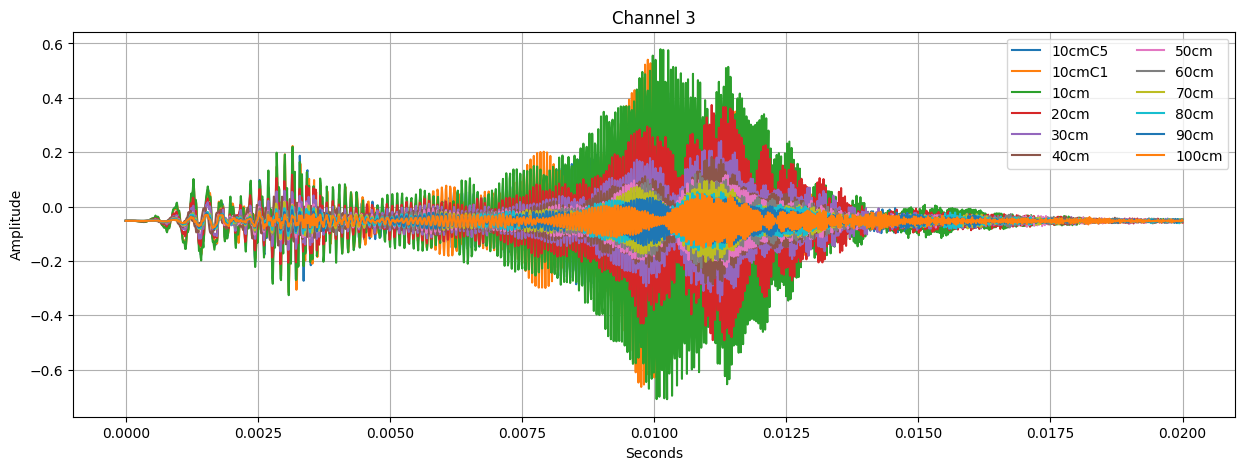

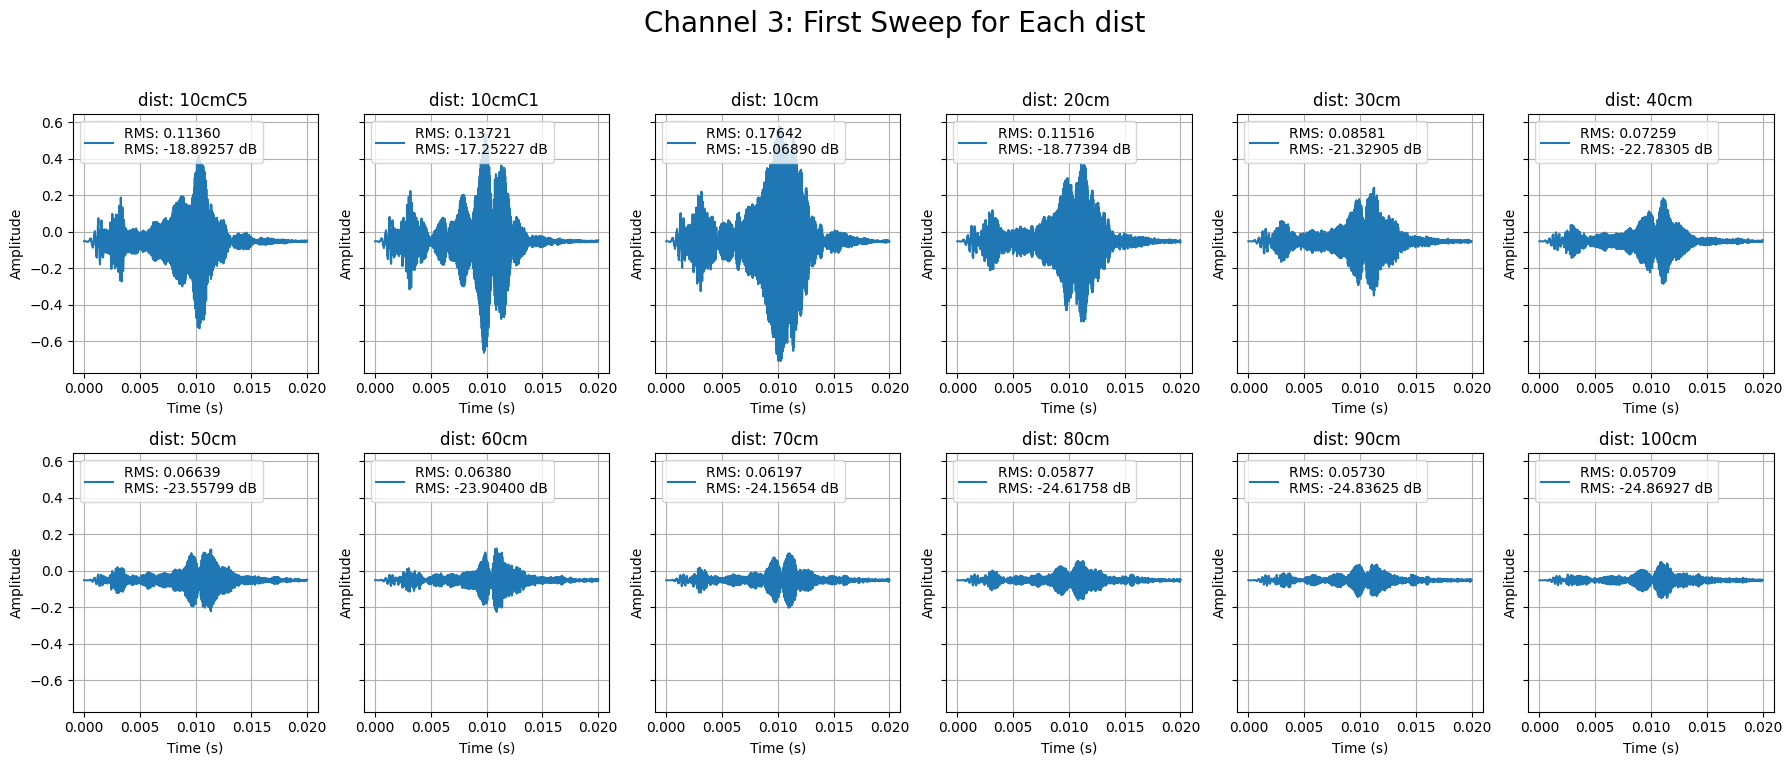

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 4:
Peaks detected in 10cmC1_4.wav: 62
RMS value of sweep at peak 9448 in 10cmC1_4.wav: 0.10389
RMS value of sweep at peak 23873 in 10cmC1_4.wav: 0.10377
RMS value of sweep at peak 39307 in 10cmC1_4.wav: 0.10445
RMS value of sweep at peak 53517 in 10cmC1_4.wav: 0.10500
RMS value of sweep at peak 68878 in 10cmC1_4.wav: 0.10475
RMS value of sweep at peak 82152 in 10cmC1_4.wav: 0.10453
RMS value of sweep at peak 96554 in 10cmC1_4.wav: 0.10450
RMS value of sweep at peak 109791 in 10cmC1_4.wav: 0.10451
RMS value of sweep at peak 124181 in 10cmC1_4.wav: 0.10441
RMS value of sweep at peak 139495 in 10cmC1_4.wav: 0.10437
RMS value of sweep at peak 154905 in 10cmC1_4.wav: 0.10499
RMS value of sweep at peak 168118 in 10cmC1_4.wav: 0.10517
RMS value of sweep at peak 182495 in 10cmC1_4.wav: 0.10488
RMS value of sweep at peak 195806 in 10cmC1_4.wav: 0.10496
RMS value of sweep at peak 208095 in 10cmC1_4.wav: 0.10507
RMS value of sweep at peak 220384 in 10cmC1_4.wav: 0.10498
RMS val

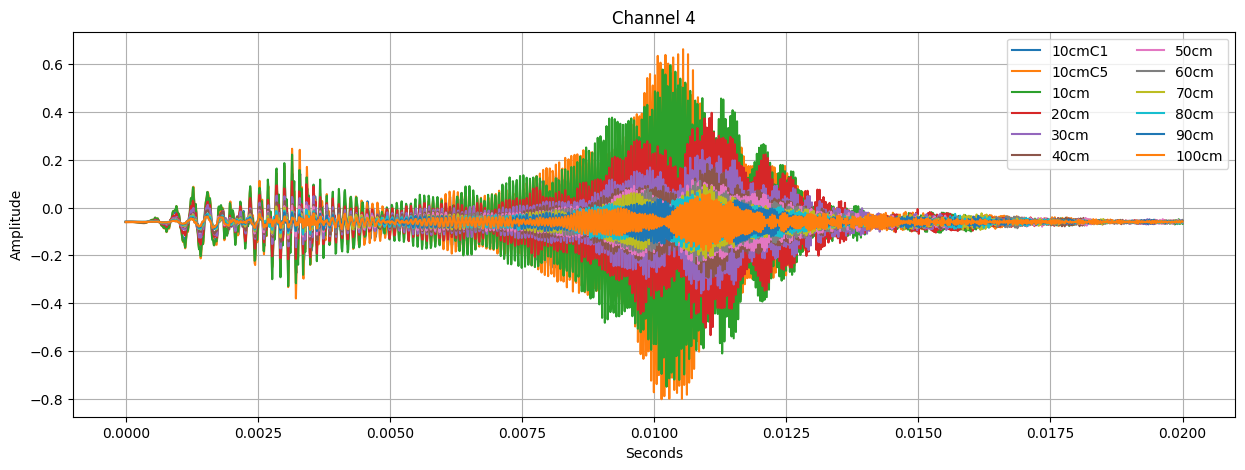

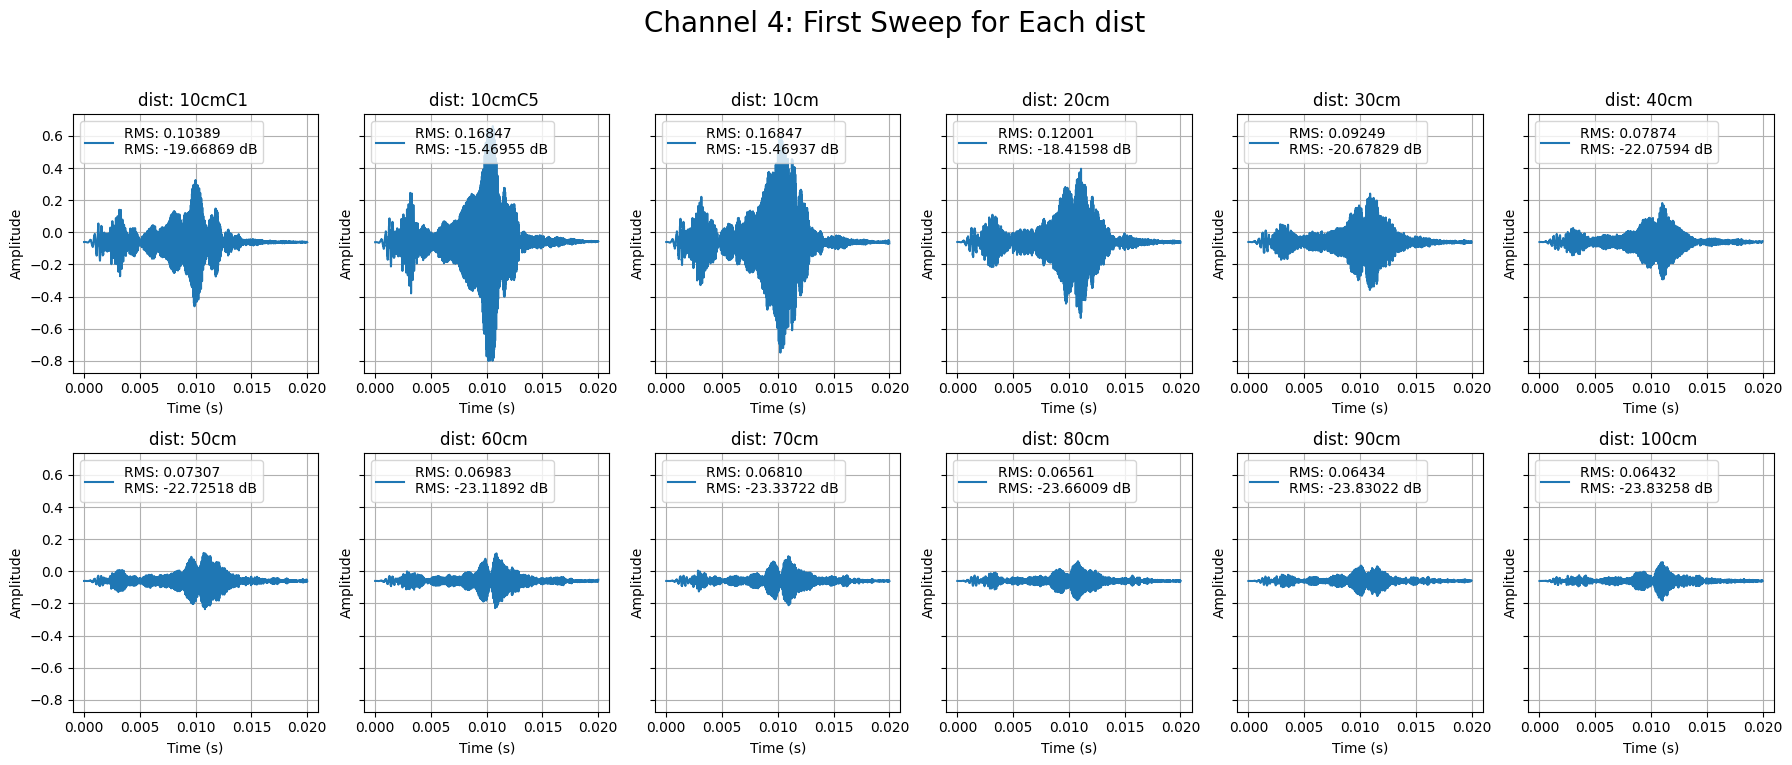

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Processing Channel 5:
Peaks detected in 10cmC1_5.wav: 62
RMS value of sweep at peak 9450 in 10cmC1_5.wav: 0.08557
RMS value of sweep at peak 23875 in 10cmC1_5.wav: 0.08561
RMS value of sweep at peak 39309 in 10cmC1_5.wav: 0.08593
RMS value of sweep at peak 53519 in 10cmC1_5.wav: 0.08601
RMS value of sweep at peak 68880 in 10cmC1_5.wav: 0.08565
RMS value of sweep at peak 82154 in 10cmC1_5.wav: 0.08542
RMS value of sweep at peak 96556 in 10cmC1_5.wav: 0.08543
RMS value of sweep at peak 109793 in 10cmC1_5.wav: 0.08554
RMS value of sweep at peak 124183 in 10cmC1_5.wav: 0.08536
RMS value of sweep at peak 139497 in 10cmC1_5.wav: 0.08538
RMS value of sweep at peak 154906 in 10cmC1_5.wav: 0.08570
RMS value of sweep at peak 168120 in 10cmC1_5.wav: 0.08562
RMS value of sweep at peak 182497 in 10cmC1_5.wav: 0.08535
RMS value of sweep at peak 195808 in 10cmC1_5.wav: 0.08529
RMS value of sweep at peak 208097 in 10cmC1_5.wav: 0.08534
RMS value of sweep at peak 220386 in 10cmC1_5.wav: 0.08525
RMS val

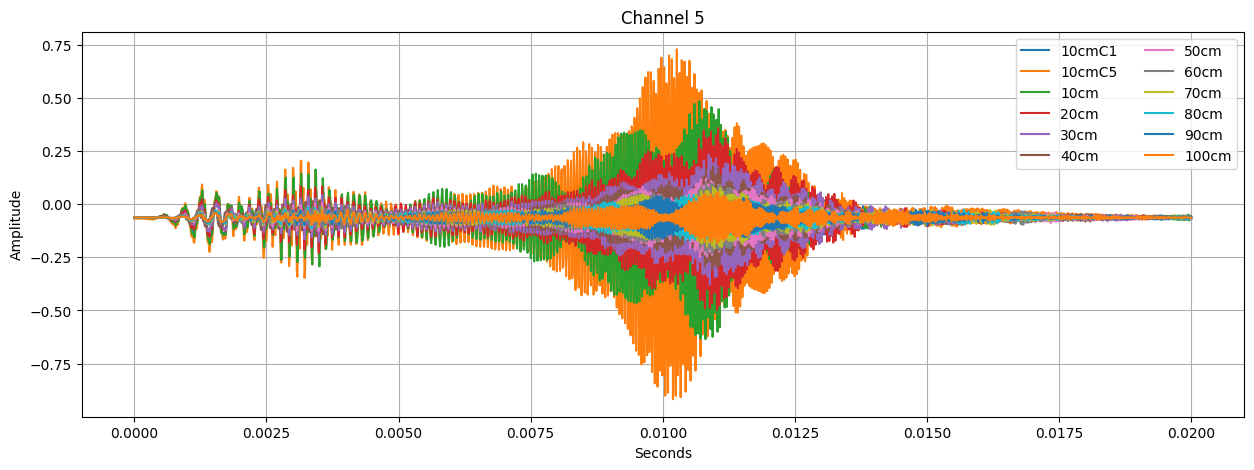

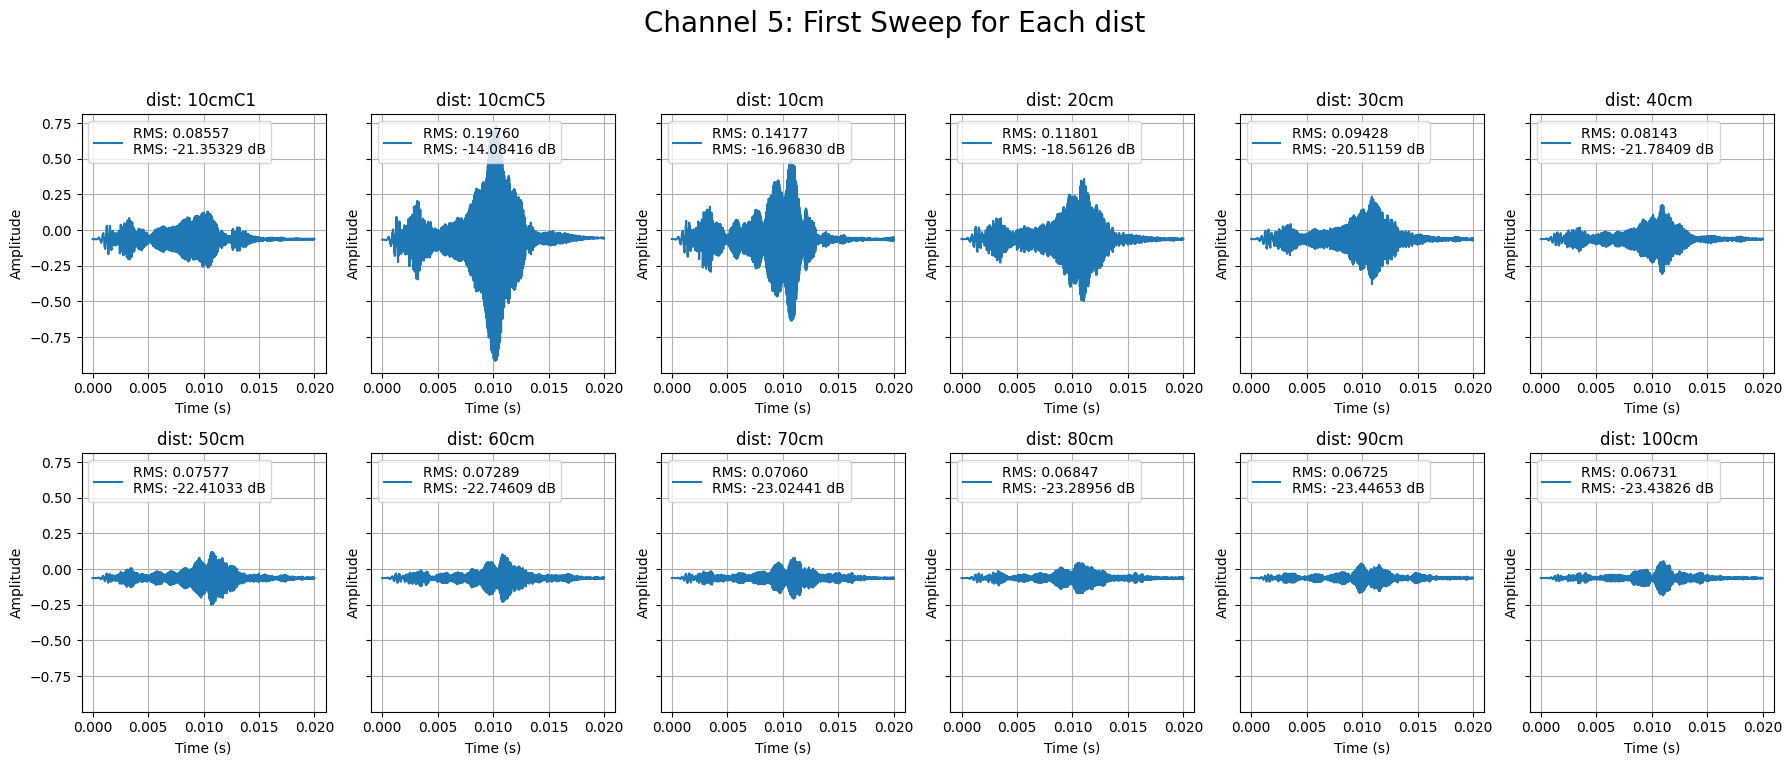

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



RMS Values for All Files:
10cmC5_1.wav: 0.07126
10cmC1_1.wav: 0.19719
10cm_1.wav: 0.13372
20cm_1.wav: 0.09828
30cm_1.wav: 0.08161
40cm_1.wav: 0.07031
50cm_1.wav: 0.06612
60cm_1.wav: 0.06258
70cm_1.wav: 0.06043
80cm_1.wav: 0.05826
90cm_1.wav: 0.05743
100cm_1.wav: 0.05678
10cmC5_2.wav: 0.09104
10cmC1_2.wav: 0.18135
10cm_2.wav: 0.17144
20cm_2.wav: 0.10970
30cm_2.wav: 0.08548
40cm_2.wav: 0.07267
50cm_2.wav: 0.06793
60cm_2.wav: 0.06488
70cm_2.wav: 0.06259
80cm_2.wav: 0.05943
90cm_2.wav: 0.05879
100cm_2.wav: 0.05823
10cmC5_3.wav: 0.11383
10cmC1_3.wav: 0.14061
10cm_3.wav: 0.17493
20cm_3.wav: 0.11391
30cm_3.wav: 0.08575
40cm_3.wav: 0.07263
50cm_3.wav: 0.06659
60cm_3.wav: 0.06396
70cm_3.wav: 0.06197
80cm_3.wav: 0.05856
90cm_3.wav: 0.05751
100cm_3.wav: 0.05681
10cmC1_4.wav: 0.10509
10cmC5_4.wav: 0.16894
10cm_4.wav: 0.16747
20cm_4.wav: 0.11911
30cm_4.wav: 0.09244
40cm_4.wav: 0.07880
50cm_4.wav: 0.07297
60cm_4.wav: 0.07005
70cm_4.wav: 0.06799
80cm_4.wav: 0.06554
90cm_4.wav: 0.06450
100cm_4.wav: 0

In [21]:
# Define the matched filter function
def matched_filter(recording, chirp_template):
    chirp_template = chirp_template[::-1]  # Time-reversed chirp
    filtered_output = signal.fftconvolve(recording, chirp_template, mode='valid')
    return filtered_output

# Detect peaks in the matched filter output
def detect_peaks(filtered_output, threshold=0.8):
    peaks, _ = signal.find_peaks(filtered_output, height=threshold * np.max(filtered_output))
    return peaks

# Process each channel
DIR_first_sweep = extracted_channels_dir + "/first_sweep/"  # Directory to save the first sweeps
os.makedirs(DIR_first_sweep, exist_ok=True)  # Create the directory if it doesn't exist

# Dictionary to store RMS values for all files
rms_values_dict = {}

channel_number = 1
for i in range(len(grouped_files)):
    files = grouped_files[i+1]
    print(f"Processing Channel {channel_number}:")
    
    # Create a new figure for each channel
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.set_title(f"Channel {channel_number}")
    ax.set_xlabel("Seconds")
    ax.set_ylabel("Amplitude")
    ax.grid(True)

    for file in files[0:(len(files))]:
        file_path = os.path.join(extracted_channels_dir, file)
        recording, sample_rate = sf.read(file_path)

        # Apply matched filtering
        filtered_output = matched_filter(recording, chirp)

        # Detect peaks
        peaks = detect_peaks(filtered_output)
        print(f"Peaks detected in {file}: {len(peaks)}")
        
        if len(peaks) > 0:
            # Extract the first sweep
            first_sweep_start = peaks[0]
            first_sweep_end = first_sweep_start + len(chirp)
            first_sweep = recording[first_sweep_start:first_sweep_end]

            # Calculate RMS values for all detected peaks
            rms_values = []
            for peak in peaks:
                sweep_start = peak
                sweep_end = sweep_start + len(chirp)
                sweep = recording[sweep_start:sweep_end]
                rms = np.sqrt(np.mean(sweep**2))
                rms_values.append(rms)
                print(f"RMS value of sweep at peak {peak} in {file}: {rms:.5f}")
            
            # Calculate the average RMS value of all peaks
            average_rms = np.mean(rms_values)
            # Store mean RMS value in the dictionary
            rms_values_dict[file] = average_rms

            print(f"Average RMS value of all sweeps in {file}: {average_rms:.5f}")

            sf.write(DIR_first_sweep + file, first_sweep, int(fs))
            # Plot the first sweep
            dist_name = file.split('_')[0]

            ax.plot(np.linspace(0,len(first_sweep),len(first_sweep))/fs, first_sweep, label=f"{dist_name}")
            ax.legend(loc = 'upper right', ncol = 2)
            print(f" {len(peaks)} sweeps detected in {file} - Channel {channel_number}")

        else:
            print(f"No sweeps detected in {file} - Channel {channel_number}")
        

    # Plot all dist
    fig1, axs = plt.subplots(2, 6, figsize=(18, 8), sharey=True)
    dist = [file.split('_')[0] for file in files]  

    idx_to_plot = 0
    for idx, file in enumerate(files):

        file_path = os.path.join(DIR_first_sweep, file)
        audio, fs = sf.read(file_path)

        rms = np.sqrt(np.mean(audio**2))
        rms_db = 20 * np.log10(rms)

        row = idx_to_plot // 6
        col = idx_to_plot % 6

        ax = axs[row, col]
        ax.plot(np.linspace(0, len(audio) / fs, len(audio)), audio)
        ax.set_title(f"dist: {dist[idx]} ")  
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Amplitude")
        ax.grid(True)
        ax.legend([f'RMS: {rms:.5f}\nRMS: {rms_db:.5f} dB'], loc='upper left')

        idx_to_plot += 1

    plt.suptitle(f"Channel {channel_number}: First Sweep for Each dist", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for suptitle
    plt.show(block = False)

    ax.legend()
    channel_number += 1

plt.show(block = False)

# Print the dictionary of RMS values
print("\nRMS Values for All Files:")
for file, rms_value in rms_values_dict.items():
    print(f"{file}: {rms_value:.5f}")

first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1337217471213313
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1714375620333341
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.1749314993171137
first rms: 0.16747113947741235
first rms: 0.16747113947741235
first rms: 0.16747113947741235
first r

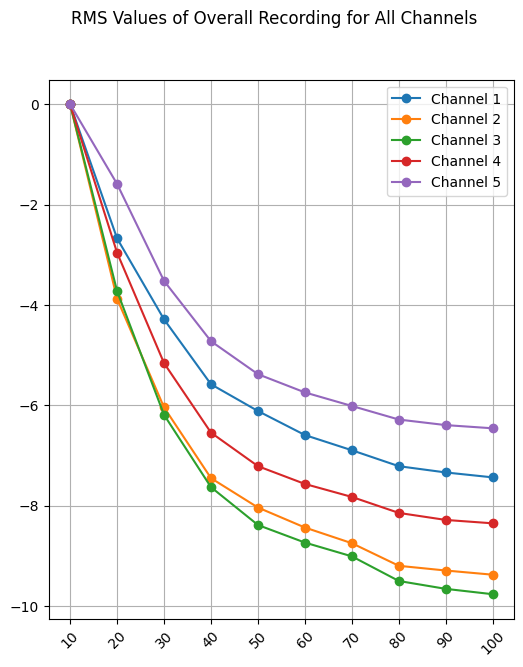

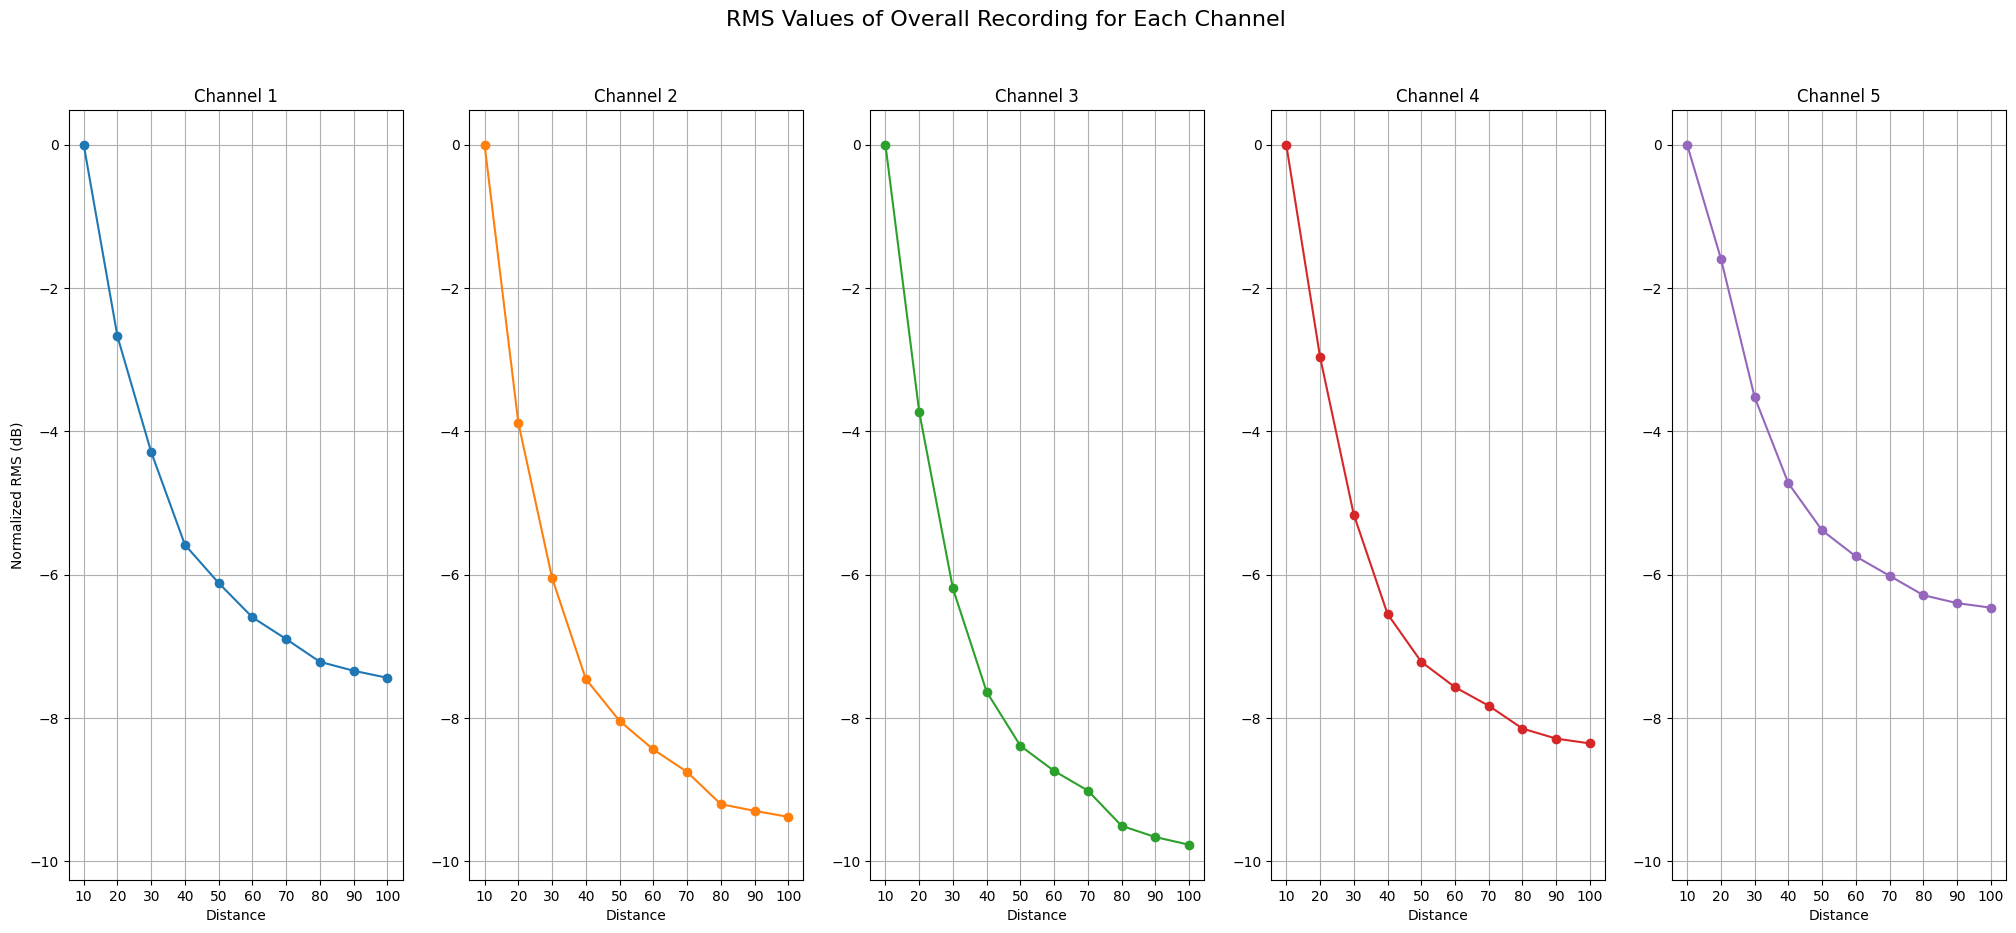

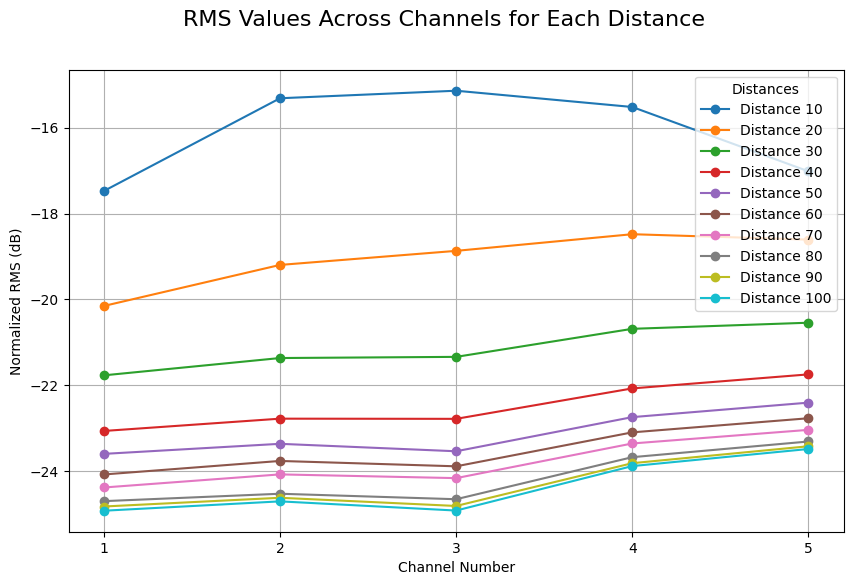

In [22]:
# RMS values of the overall recording for each channel and each angle

num_channels = len(grouped_files)

# Linear plot of all channels
fig_linear, ax_linear = plt.subplots(figsize=(6, 7))
fig_linear.suptitle("RMS Values of Overall Recording for All Channels", fontsize=12)

# Subplots for each channel
fig_channels, axs_channels = plt.subplots(1, num_channels, figsize=(5*num_channels,10))
fig_channels.suptitle("RMS Values of Overall Recording for Each Channel", fontsize=16)

# Plotting RMS values for each channel
angles = np.linspace(0, 360, 18, endpoint=False)  # Angles for each measurement
rms_values_channel = {}

# Collect RMS values for each channel

channel_data = {}
norm_channel_data = {}

for file, rms_value in rms_values_dict.items():
    if 'C' in file:
        continue

    dist_name = file.split('c')[0]
    channel_number = int(file.split('_')[-1].split('.')[0])

    if channel_number not in channel_data:
        channel_data[channel_number] = {'distances': [], 'rms_values': []}

    if channel_number not in norm_channel_data:
        norm_channel_data[channel_number] = {'distances': [], 'rms_values': []}

    channel_data[channel_number]['distances'].append(dist_name)
    norm_channel_data[channel_number]['distances'].append(dist_name)

    if len(channel_data[channel_number]['distances']) == 0:
        pass#channel_data[channel_number]['rms_values'].append(20 * np.log10(rms_value/max_rms))
    else:
        first_distance = norm_channel_data[channel_number]['distances'][0]
        first_rms = rms_values_dict[first_distance+'cm_'+ str(channel_number)+'.wav']
        print(f"first rms: {first_rms}")
        norm_channel_data[channel_number]['rms_values'].append(20 * np.log10(rms_value/first_rms))

        channel_data[channel_number]['rms_values'].append(20 * np.log10(rms_value))


for channel_number, data in norm_channel_data.items():
    ax_linear.plot(data['distances'], data['rms_values'], marker='o', linestyle='-', label=f'Channel {channel_number}')
    print(f"Channel {channel_number}: {data['rms_values']}")
    ax_linear.tick_params(axis='x', rotation=45)
    ax_linear.grid(True)
    ax_linear.legend()
    
    # Plotting each channel in a separate subplot
    color = ax_linear.get_lines()[-1].get_color()  # Get the color of the last line in ax_linear
    ax_channel = axs_channels[channel_number-1]
    ax_channel.plot(data['distances'], data['rms_values'], marker='o', linestyle='-', label=f'Channel {channel_number}', color=color)
    ax_channel.set_title(f'Channel {channel_number}')
    ax_channel.set_xlabel('Distance')
    if channel_number == 1:
        ax_channel.set_ylabel('Normalized RMS (dB)')
        ax_channel.yaxis.set_label_position("left")
    ax_channel.grid(True)
    ax_channel.sharey(axs_channels[0])

# Plot RMS values across channels for each distance
fig_distances, ax_distances = plt.subplots(figsize=(10, 6))
fig_distances.suptitle("RMS Values Across Channels for Each Distance", fontsize=16)

distance_data = {}

for channel_number, data in channel_data.items():
    for dist, rms in zip(data['distances'], data['rms_values']):
        if dist not in distance_data:
            distance_data[dist] = []
        distance_data[dist].append(rms)

for dist, rms_values in distance_data.items():
    ax_distances.plot(range(1, len(rms_values) + 1), rms_values, marker='o', linestyle='-', label=f'Distance {dist}')
    print(f"Distance {dist}: {rms_values}")

ax_distances.set_xlabel('Channel Number')
ax_distances.set_xticks(range(1, len(rms_values) + 1))
ax_distances.set_ylabel('Normalized RMS (dB)')
ax_distances.grid(True)
ax_distances.legend(title="Distances", loc='upper right')

plt.grid(True)
plt.show(block=False)

fig_channels.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show(block=False)
